In [1]:
!nvidia-smi

Sun Aug 20 19:10:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/rohit-krish/Deeplex.git
%cd Deeplex

Cloning into 'Deeplex'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (303/303), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 303 (delta 144), reused 225 (delta 90), pack-reused 0
Receiving objects: 100% (303/303), 619.05 KiB | 13.46 MiB/s, done.
Resolving deltas: 100% (144/144), done.
/content/Deeplex


### Imports

In [3]:
from deeplex.engine import Tensor, no_grad
from deeplex import nn, optim
from deeplex.nn import functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sb

plt.style.use(plt.style.available[11])


### Create Data

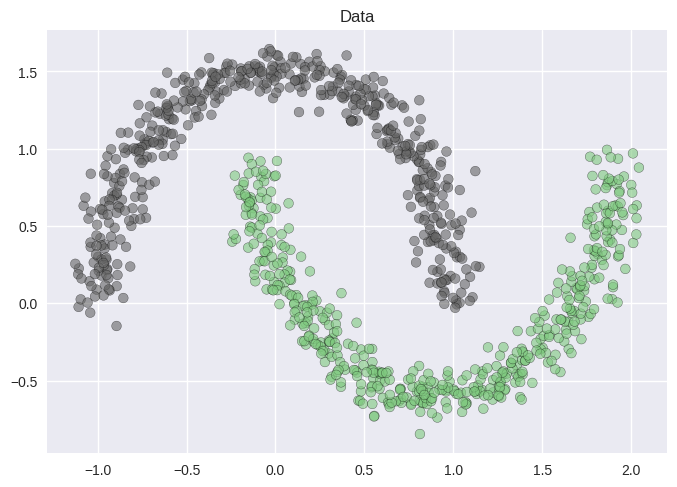

In [4]:
import numpy as np

N = 500
th1 = np.linspace(0, np.pi, N)
th2 = np.linspace(np.pi, 2*np.pi, N)

noise = np.random.randn(2, N) / 12

circ_piece_fliped_1 = np.array((np.cos(th1), np.sin(th1)*1.5)) + noise          # upper piece
circ_piece_fliped_2 = np.array((np.cos(th2), np.sin(th2)*1.5)) + noise + 0.9    # lower piece
X = np.hstack((circ_piece_fliped_1, circ_piece_fliped_2)).T

y = np.hstack((np.zeros(N), np.ones(N)))

plt.title('Data')
plt.scatter(X[:, 0], X[:, 1], alpha=.6, edgecolors='k', c=y, cmap='Accent_r')
# plt.axis('square')
plt.show()


In [5]:
X, y = Tensor(X), Tensor(y)
X.shape, y.shape

((1000, 2), (1000,))

### Define Model

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, n_out, device):
        super().__init__(device)
        self.l1 = nn.Linear(n_in, 6, device=device)
        self.l2 = nn.Linear(6, 9, device=device)
        self.l3 = nn.Linear(9, n_out, device=device)

    def __call__(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.sigmoid(self.l3(x))
        return x


### Training

In [22]:
device = 'cuda'
losses = []

X.to(device)
y.to(device)

model = Model(2, 1, device)

lr = .009
n_epochs = 400
optimizer = optim.Adam(model.parameters(), lr=lr, device=device)


In [23]:
loop = tqdm((range(n_epochs)))

for epoch_i in loop:
    yHat = model(X).reshape(-1)
    loss = F.BCELoss(y, yHat)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.get())
    loop.set_postfix(loss=loss.data.get())


100%|██████████| 400/400 [00:02<00:00, 142.13it/s, loss=0.00608423]


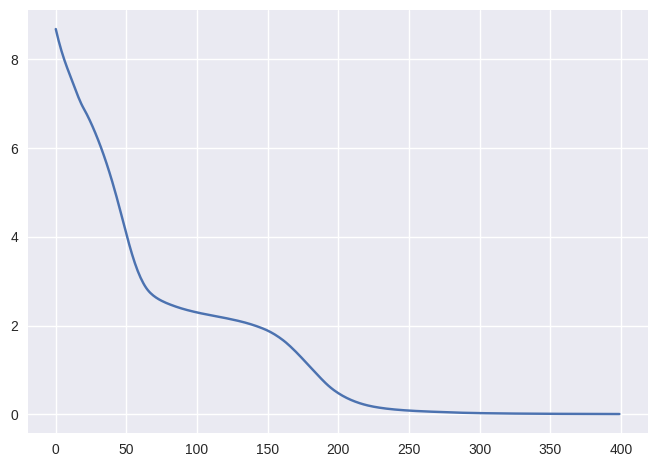

In [24]:
plt.plot(losses)
plt.show()


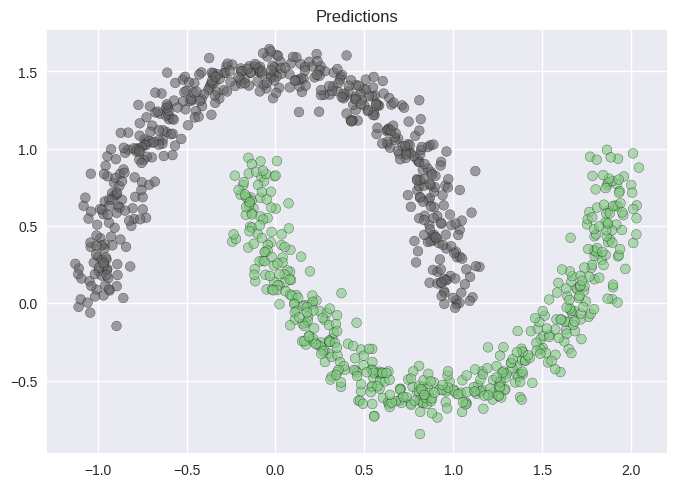

In [25]:
with no_grad():
    preds = model(X).data.get().reshape(-1).round()

X_ = X.data.get()

plt.title('Predictions')
plt.scatter(X_[:, 0], X_[:, 1], alpha=.6, edgecolors='k', c=preds, cmap='Accent_r')
plt.show()


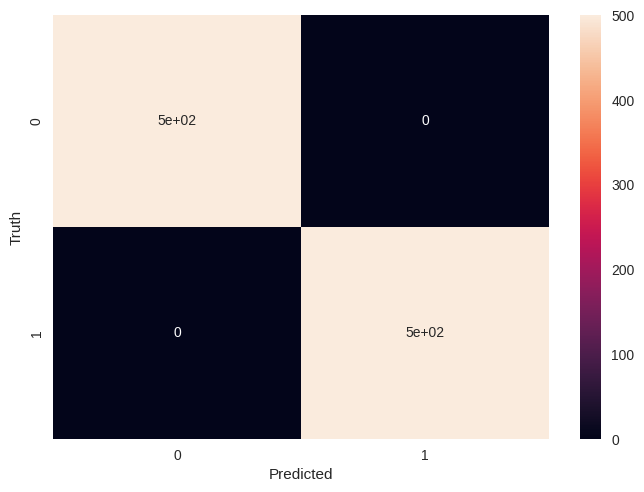

In [26]:
y_ = y.data.get().round().astype('int')
preds_ = preds.astype('int')

cmap = confusion_matrix(y_, preds_)
sb.heatmap(cmap, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [27]:
print(classification_report(y_, preds_))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



### Suddenly a nerd comes in.. 😁

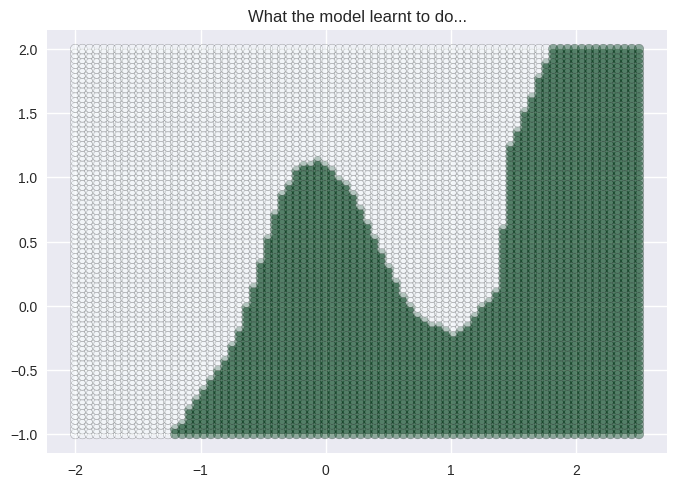

In [29]:
xx, yy = np.meshgrid(np.linspace(-2, 2.5, 80), np.linspace(-1, 2, 80))
xx, yy = xx.reshape(-1), yy.reshape(-1)
XX = np.vstack([xx, yy]).T

XX = Tensor(XX, device=device)

with no_grad():
    preds = model(XX).data.get().reshape(-1).round()

XX = XX.data.get()

plt.title('What the model learnt to do...')
plt.scatter(XX[:, 0], XX[:, 1], alpha=.4, edgecolors='k', c=preds, cmap='BuGn')
plt.show()
